In [7]:
!pip install transformers

In [8]:
!nvidia-smi

Tue Jun  9 22:17:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from transformers import *
from torch.utils.data import Dataset, DataLoader


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def seed_all(seed):
  random.seed(seed)
  torch.manual_seed(seed)
  np.random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_all(34)


In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doanquanvietnamca","key":"5c44ad334dfc534e12d04dc8373e0440"}'}

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 96.4MB/s]
 34% 9.00M/26.3M [00:00<00:00, 18.5MB/s]
100% 26.3M/26.3M [00:00<00:00, 44.9MB/s]
 21% 5.00M/23.4M [00:00<00:01, 14.2MB/s]
100% 23.4M/23.4M [00:00<00:00, 47.7MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 209MB/s]


In [13]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!mkdir data
!mv *.csv data

In [0]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [16]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


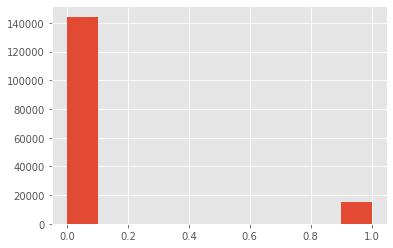

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn
plt.style.use('ggplot')
np.random.seed(0)
train['toxic'].hist()


In [0]:
train['comment_text'].replace('\n', ' ', regex=True, inplace=True)

In [19]:
#Text processing
#preprocessing data.
#remove punc, html, stop works,
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['comment_text']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(" ".join(lemma_words))

    return(reviews)
train['comment_text'] = clean_sentences(train)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


 41%|████      | 64885/159571 [00:53<01:14, 1268.44it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 48%|████▊     | 76030/159571 [01:02<01:07, 1233.88it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 67%|██████▋   | 106859/159571 [01:26<00:42, 1228.53it/s]/usr/

In [20]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he match this background colour i m seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestion on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [0]:
from sklearn.model_selection import train_test_split
df = train
train, valid = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
class JSAWDataset(Dataset):
  def __init__(self, df):

    self.targets = df[[	'toxic',	'severe_toxic',\
                            'obscene',	'threat',	'insult',	'identity_hate']].values
    self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    self.inputs = []
    self.len = len(df)
    self._build(df["comment_text"].values)
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze

    return (source_ids,src_mask,\
            torch.tensor(self.targets[index]).squeeze())
  
  def _build(self,text):
    for idx in range(self.len):
      input_ =  text[idx]
      input_ =  '<s> %s </s>'%str(input_)
      
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=128, pad_to_max_length=True, return_tensors="pt"
      )
      self.inputs.append(tokenized_inputs)


In [23]:
traindataset = JSAWDataset(train)
validdataset = JSAWDataset(valid)


NameError: ignored

In [0]:
x_train ,x_mask, y_train = traindataset[1]

In [0]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
sample = RandomSampler(traindataset)
trainloader = DataLoader(traindataset ,sampler=sample, batch_size= 16)

sample = RandomSampler(validdataset)
validloader = DataLoader(validdataset ,sampler=sample, batch_size= 16)

In [0]:
class RobertaMultilayerClassification(torch.nn.Module):
    def __init__(self):
        super(RobertaMultilayerClassification,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.dense = torch.nn.Linear(768, 6)
        torch.nn.init.xavier_normal_(self.dense.weight)

    def forward(self, ids , attention_mask=None,token_type_ids=None):
        last_hidden_state = self.model(input_ids=ids, attention_mask = attention_mask,token_type_ids= token_type_ids)
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        #mean_last_hidden_state = self.dropout(mean_last_hidden_state)
        logits = self.dense(mean_last_hidden_state)
        return torch.sigmoid(logits)
    def pool_hidden_state(self, last_hidden_state):
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
        #return last_hidden_state

In [48]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(use_cuda)

True


In [56]:
#@title Check availble memory of GPU
# Check that we are using 100% of GPU
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 9.7 GB  | Proc size: 6.2 GB
GPU RAM Free: 4066MB | Used: 11013MB | Util  73% | Total 15079MB


In [0]:
roberta = RobertaMultilayerClassification()

In [0]:
optim = torch.optim.AdamW(params=roberta.parameters(), lr=2e-5,weight_decay=0.01)
loss = torch.nn.BCEWithLogitsLoss()

In [0]:
def binary_cross_entropy(pred, y): 
  return -(pred.log()*y + (1-y)*(1-pred).log()).mean()

In [0]:
from tqdm import tqdm
from torch.autograd import Variable
def fit_cycle( model, epochs, optim , train_loader , valid_loader, device):
    model.train()
    model.to(device)

    for i in range(epochs):
        loss_set = []
        steps = 0
        loss_sum  = 0
        for batch in tqdm(train_loader):
            x_train ,x_mask, y_train = batch
            x_train = Variable(x_train).cuda(device)
            x_mask  = Variable(x_mask).cuda(device)
            y_train = Variable(y_train).cuda(device)
            ypred = model(x_train, attention_mask=x_mask)
            optim.zero_grad()
            loss = binary_cross_entropy(ypred,y_train)
            loss_sum += loss
            steps +=y_train.shape[0]
            loss.backward()
            optim.step()
            loss_set.append(loss_sum/steps)
        if(steps%100):
            print("step %d: Loss %f"%(steps, loss_sum/steps))
    model.eval()
    valid_set = []
    steps = 0
    loss_sum  = 0
    for batch in tqdm(valid_loader):
            x_train ,x_mask, y_train = batch
            x_train = Variable(x_train).cuda(device)
            x_mask  = Variable(x_mask).cuda(device)
            y_train = Variable(y_train).cuda(device)
            ypred = model(x_train, attention_mask=x_mask)
            with torch.no_grad():
                loss = torch.nn.BCEWithLogitsLoss(ypred,y_train)
                loss_sum += loss
                steps +=y_train.shape[0]
                valid_set.append(loss_sum/steps)
    return model,loss_set,valid_set

In [0]:
model , loss_set, valid_set = fit_cycle(roberta, 1,optim, trainloader, validloader, device = device)

  5%|▍         | 367/7979 [02:20<48:02,  2.64it/s]

In [0]:

import matplotlib.pyplot as plt
plt.plot(loss)
plt.plot(valid)
plt.show()